# Predicting the Cost of Single Family Homes



## Project Goals

- Discover drivers behind housing prices.

- Use those drivers to build a model that accurately predicts housing prices

- Deliver a report that a non-technical person can read and understand the steps taken, why they wre taken, and the outcomes.


## Imports Used

In [1]:
#basic data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#imports for stats tests
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr, spearmanr

#imports for stats functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

#imports for feature engineering and modeling
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor

#importing created .py files
import acquire
import prepare
import explore
import model

#so that charts show how I want
%matplotlib inline
pd.options.display.max_columns = None

#ignore red warning boxes
import warnings
warnings.filterwarnings("ignore")

#setting a seed for reproducibility
seed = 42

# Acquire

- I obtained my data from the Codeup MySQL server


- Data was pulled from the server on 01/19/2023


- The dataset, when I started, was 56080 rows by 8 columns


- Each row represents a house, while each column is a feature of that house

In [2]:
#this pulls my data either from a .csv file I created, or directly from the server, 
#and then it saves that data to a .csv
df = acquire.get_zillow()

In [3]:
#grabbing the head row to check the column names
df.head(1)

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,10804942,3.0,2.0,1175.0,327859.0,1953.0,4050.73,6037.0


# Prepare

After acquiring my data, I had to prepare it. To do so, I:

- Checked for null fields

    - There was only a small number of nulls, so I just dropped each row with a null value within
    
    
- Checkfor outliers

    - There was a decent amount of outliers, so I started with only removing a small percentage. My data still showed skew, though, so I ended up removing a few thousand rows in the end from my data. My models did end up benefitting quite a lot from this.
    
    
- I ended up renaming most columns to something more manageable, as well as dropping a few that weren't useful.

In [4]:
#this functions does everything mentioned above except for remove the outliers
df = prepare.prep_zillow(df)
df.head(1)

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0


In [5]:
#for my outlier function to, well, function properly, 
#I need to set a variable name for the columns I want to check
cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'year_built', 'fips']

In [6]:
#function that removes my outliers
df = prepare.remove_outliers(df, 2, cols)
df.head(1)
#I end up losing almost 9000 rows between dropping my null values, and removing outliers, 
#but, as stated above, my model improves quite a lot for it.

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0


In [7]:
#this function splits my data into trai, validate and test subsets as well as printing off the shape of each
train, validate, test = prepare.subset_df(df)

(27650, 6) (9217, 6) (9217, 6)


# Exploration

## Do bedroom and bathroom counts have a relationship?

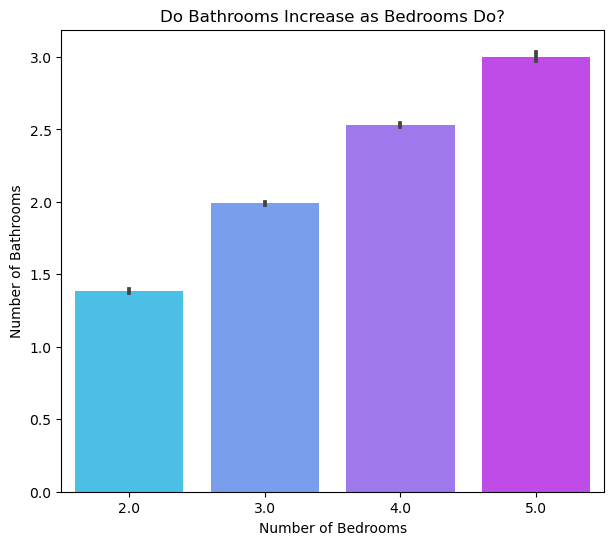

In [8]:
#function created for visual
explore.first_viz(train)

- The main takeaaway here is that it's pretty clear here that there's a relationship between the bedrooms and bathrooms here

- Additionally, with how much these two features seem to be correlated, it might not be a good idea to model with them both. 

- As it's pretty clear there's at least *something* of a relationship, I chose not to perform any statistical tests at this time.


## Does year built have an effect on the number of bedrooms?

## Does year built have a relationship with the square feet of the house?  

## Does fips have a relationship with the square feet?

## Is there a relationship between bathrooms and fips?